In [54]:
#Import the libraries
import pandas as pd
import seaborn as sns
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, scale
from sklearn.ensemble import  AdaBoostClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

### Section 1: Business Understanding (a brief description of the problem and questions of interest)
Today every business would like to predict when a client is going to leave the company, for this reason, is important to get the knowledge and competences related to the discovery of oportunities and facts of the business to give more chances to survive on market. For this reason, in this notebook we are gonna doing some analysis to discover if we can predict if a cliente is going to leave or not a telco company. This notebook was made as a homework from the Udacity Datascientist nanodegree.
To undestand on a better way this work, Im going to describe what are we doing on this notebook and what question we are going to answer.

<p><b>Question 1:</b>  What kind of clients are leaving the company</p>
<p><b>Question 2:</b>  Which products are the most popular?</p>
<p><b>Question 3:</b>  Wich products are causing more churn?</p>
<p><b>Question 4:</b>  Which kind of contract are our clients getting on?</p>
<p><b>Question 5:</b>  Can we predict the clients leaving?</p>

And finally, to solve the questions, we are going to use crisp-dm methodology, that consist on the next steps:

<p><b>Business Understanding</b></p>
<p><b>Data Understanding</b></p>
<p><b>Prepare Data </b></p>
<p><b>Data Modeling</b></p>
<p><b>Evaluation</b></p>

### Section 2: Data understanding
First of all is necesary get the knowledge from the data that we are working on, for this reason, we are going to load the data from a file and then review this

In [55]:
#Load the data
data = pd.read_csv('telco_churn.csv')
#Get the 5 first rows
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [56]:
#Checking nulls
data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

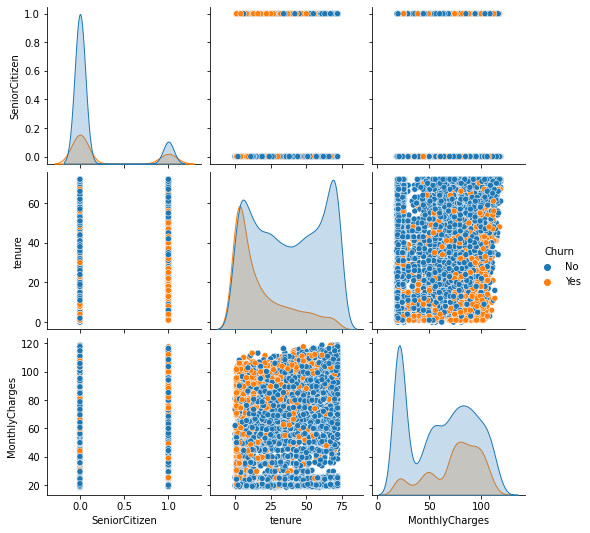

In [57]:
##Show the pairplot to get a knowledge from data
sns.pairplot(data = data,hue="Churn")

### Question Number One: What kind of clients are leaving the company
After the first analysis we can see what kind of clients are leaving the company,
First: Those clientes with less time on the company and second, those clients who pays more for a service, we are going to show this on detail in the next graph

<AxesSubplot:xlabel='tenure', ylabel='MonthlyCharges'>

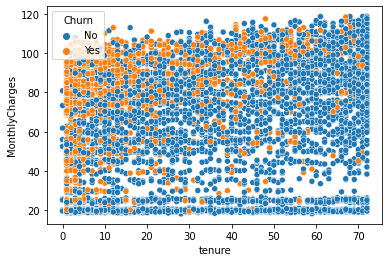

In [58]:
#Wich kind of pays vs tenure is leaving the company??
#Clearly the clients who pays more and gets a tenure before 25 / 30 months
sns.scatterplot(data=data,x='tenure',y='MonthlyCharges',hue= 'Churn')

### Question Number Two: Which products are the most popular?
### Question Number Three: Wich products are causing more churn?
To Solve this two questions, we are going to model and show 4 graphs and then answer the two questions wrote before

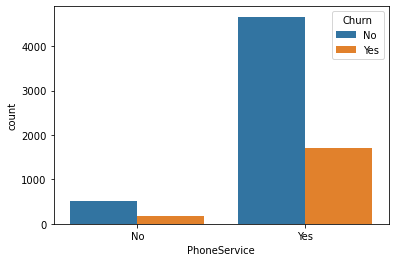

In [59]:
ax = sns.countplot(x="PhoneService", hue="Churn", data=data)

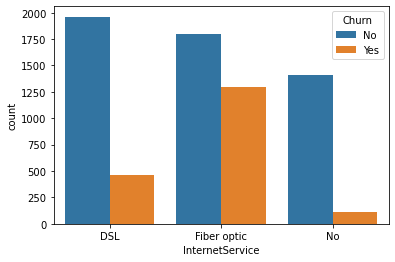

In [60]:
ax = sns.countplot(x="InternetService", hue="Churn", data=data)

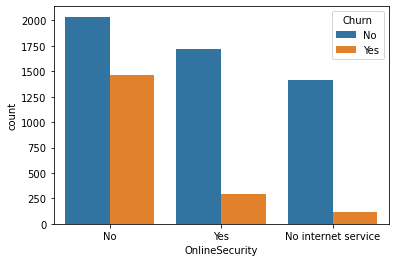

In [61]:
ax = sns.countplot(x="OnlineSecurity", hue="Churn", data=data)

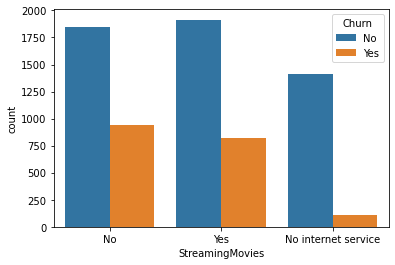

In [62]:
ax = sns.countplot(x="StreamingMovies", hue="Churn", data=data)

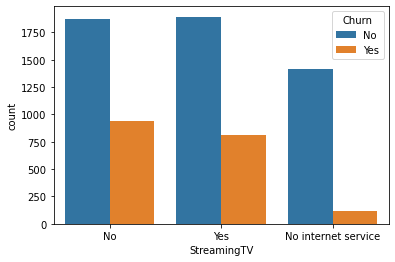

In [63]:
ax = sns.countplot(x="StreamingTV", hue="Churn", data=data)

### Answers:
Watching at the four graphs, we can deduce that the most popular products are <b>Phone Service</b> and <b>Internet Service</b> (Answer to question 2).
After see the last four graphs, we can deduce too the products that are cause the leaving from the company, this products are <b>Phone Service</b> and <b>Internet Service</b>, in Phone Service, we can deduce that Fiber optic is the most critical service (Answer to question 3).


### Question Number Four: Which kind of contract are our clients getting on?
To try to prevent the churn, is necesary analyze wich kind of contracts are getting our clients, why?? Because this is gonna to describe our clients and is a good insight to know how to manage them

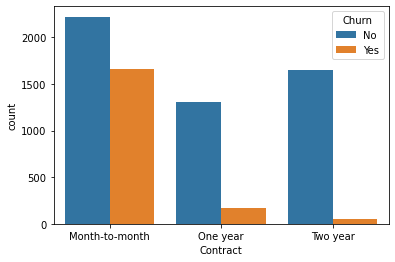

In [64]:
ax = sns.countplot(x="Contract", hue="Churn", data=data)

After this we can see that our clients who contract by years aren't leaving the company, this is imporant, because the clients who trust in the company for a long time, are not leaving, finally, we can see too that the clients that are leaving the company are those who pays month by month

### Section 3: Data preparation
The next step is prepare our predictor, to do this, is necesary get the knowledge from the data (Data understanding) and define what is necesary to clean this, in the next step we are going to do some preps to work this data in a better way

<AxesSubplot:>

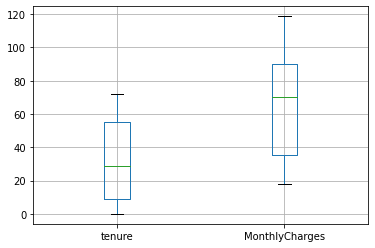

In [83]:
#Look if the data needs to be normalized
data.boxplot(column=['tenure','MonthlyCharges'])

In [87]:
#Transforming data to numeric format
def transform_data_tonumber(data):
    '''
    DEF: Function used to transform text data to number
    INPUT:
        data: This is the data that is going to be transformed
    OUTPUT:
        data: This is the data transformed
    '''
    #ternure to number
    data['tenure'] = data['tenure'].astype(float)
    #monthly charges to number
    data['MonthlyCharges'] = data['MonthlyCharges'].astype(float)
    #Replacing blank with 0
    data.loc[(data['TotalCharges'] == ' '),'TotalCharges']=0
    #Transforming to float
    data['TotalCharges'] = data['TotalCharges'].astype(float)
    return data
data = transform_data_tonumber(data)

In [88]:
#Encode the data to build a predictor (Y predictor, category to number)
#Transform Y to 1 and 0
labelencoder = LabelEncoder()
data['Churn'] = labelencoder.fit_transform(data['Churn'])

In [89]:
#Define X
X =data.iloc[:,1:-1]
#Define y
y = data.iloc[:,-1]

In [90]:
#Review of X
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,0,Yes,No,1.0,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,Male,0,No,No,34.0,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50
2,Male,0,No,No,2.0,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
3,Male,0,No,No,45.0,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,Female,0,No,No,2.0,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65


In [91]:
#Review of Y
y.head()

0    0
1    0
2    1
3    0
4    1
Name: Churn, dtype: int64

In [92]:
#Remove totalCharges (directly corretaled to ternumer and monthlycharges)
X.drop('TotalCharges',axis=1,inplace=True)
#Change TotalCharges to float
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges
0,Female,0,Yes,No,1.0,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85
1,Male,0,No,No,34.0,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95
2,Male,0,No,No,2.0,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85
3,Male,0,No,No,45.0,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30
4,Female,0,No,No,2.0,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70


### Question Number Five: Can we predict the clients leaving?
### Section 4: Data modeling
This step is necessary to build a better predictor, this is the normalization of the data

In [93]:
def prepare_data_to_ml(data):
    '''
    DEF: Method to prepare the data to be normalized, this scales the data and categorice this using get_dummies() method
    INPUT:
        data: Data to be transformed
    OUTPUT:
        X: Data transformed   
    '''
    std_scaler = StandardScaler(with_mean=True,with_std=True)
    scaled_data = data[['tenure','MonthlyCharges']]
    data_scaled = std_scaler.fit_transform(scaled_data)
    X_resp = pd.concat([X.drop(columns=['tenure','MonthlyCharges'],axis=1),pd.DataFrame(data_scaled,columns=['scaled_ternure','scaled_MonthlyCharges'])],axis=1)
    #One hot encode using get_dummies the categorical data
    for c in X_resp.select_dtypes(include=['object']).columns:
        X_resp = pd.concat([X_resp.drop(c,axis=1),pd.get_dummies(X_resp[c],prefix=c, prefix_sep='_',drop_first=True)],axis=1)
    return X_resp
X = prepare_data_to_ml(data)

In [94]:
#Show 5 first rows of data transformed
X.head()

,SeniorCitizen,scaled_ternure,scaled_MonthlyCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,-1.277445,-1.160323,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
1,0,0.066327,-0.259629,1,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0,-1.236724,-0.362660,1,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,0,0.514251,-0.746535,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,-1.236724,0.197365,0,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,1,0


In [95]:
#Define X train and y_train
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, random_state=42)

In [96]:
#Create the predictor
ad = AdaBoostClassifier(learning_rate= 0.1,n_estimators= 700)

In [97]:
#Fit the classifier
ad.fit(X_train,y_train)
#Make predictions for test data
y_pred = ad.predict(X_test)

### Section 5: Evaluation metrics
Finally, is necessary evaluate the model to avoid mistakes, this predictor must have higher evaluation metrics to get a good predictor of churning clients

In [80]:
def evaluation_metrics(y_test,y_pred):
    '''
    DEF: Method to show the evaluation metrics from the predictor
    INPUT:
        estimator: This is the predictor to be improved
        grid: Grid of params
    OUTPUT:
        None    
    '''
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    print("Evaluation Metrics")
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Precision: %.2f%%" % (precision * 100.0))
    print("Recall: %.2f%%" % (recall * 100.0))
    print(classification_report(y_test, y_pred))
    print(pd.crosstab(y_test, y_pred, rownames = ['Actual'], colnames =['Predicted'], margins = True))
    print(ad)
evaluation_metrics(y_test,y_pred)

Evaluation Metrics
Accuracy: 81.26%
Precision: 67.52%
Recall: 56.30%
              precision    recall  f1-score   support

           0       0.85      0.90      0.88      1036
           1       0.68      0.56      0.61       373

    accuracy                           0.81      1409
   macro avg       0.76      0.73      0.75      1409
weighted avg       0.80      0.81      0.81      1409

Predicted     0    1   All
Actual                    
0           935  101  1036
1           163  210   373
All        1098  311  1409
AdaBoostClassifier(learning_rate=0.1, n_estimators=700)


In [82]:
def look_for_best_params(estimator,grid):
    '''
    DEF: Method to look up for the best params for a predictor
    INPUT:
        estimator: This is the predictor to be improved
        grid: Grid of params
    OUTPUT:
        None    
    '''
    #Build GridSearchCV to ada
    ad_mse = GridSearchCV(estimator = estimator, param_grid = grid, scoring = 'neg_mean_squared_error', cv = 5, verbose = 1)
    #Start GridSearchCV
    ad_mse.fit(X_train, y_train)

    #Best params
    print("Best parameters found: ",ad_mse.best_params_)
    print("Lowest RMSE found: ", np.sqrt(np.abs(ad_mse.best_score_)))

#Build GridSearchCV to Ada booster
ad_param_grid = {
    'n_estimators': [400,600,700,800],
    'learning_rate':[0.1,0.3,0.5,1]
} 
look_for_best_params(ad,ad_param_grid)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  3.2min finished


Best parameters found:  {'learning_rate': 0.1, 'n_estimators': 700}
Lowest RMSE found:  0.4476509032053147


In [30]:
print("Work Finished")

Work Finished


### Conclusions
Here are the conclusions of the project:
<li>Data is important now because we can get knowledge from the experience from our clients, get what are the critical areas from the company, where are the gaps and finally, where is the company doing a good work.</li>
<li>Is important define strategies (not touched in this exercise) to solve the gaps presented on the company (for example the gaps on phone service and internet service to prevent churn from our clients).</li>
<li>Finally, is important try to get everyday more data, for this exercise, a good example of this is add the data coming from service status and relate this with the clients that leave the company, another example is get data from where is our company not giving a good service. The most important here, as I said before, is try to enrich our models everyday with new data, this bring us to the predictor (ada booster), with this, our model probably is going to give us a better answer too and predict when a client is going to leave the company.</li>

### Acknowledgements
Link the te data used in this can be found on the next link: https://www.kaggle.com/blastchar/telco-customer-churn


# LINK TO THE ARTICLE

https://jcruzcat.medium.com/can-we-predict-clients-churn-an-initial-aproach-to-ds-ce550857c933


